# iCNT — Ultimate Notebook
Dual-channel CNT/iCNT testbed with multi-glyph atlas, real-data embedding, diagnostics, and atlas→data mapping.

**Outputs** will be written to `./outputs/` next to this notebook.


## 0) Setup

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, json, os
from pathlib import Path
OUT = Path('./outputs'); OUT.mkdir(exist_ok=True)

def order_parameter(phases):
    z = np.exp(1j * phases).mean()
    return np.abs(z)

def pairwise_phase_diff(phases):
    diffs = np.abs(np.subtract.outer(phases, phases))
    diffs = np.minimum(diffs, 2*np.pi - diffs)
    return diffs[np.triu_indices_from(diffs, 1)].mean() / np.pi

def rank_to_angle(x):
    r = pd.Series(x).rank(method='average').to_numpy()
    r = (r - r.min()) / (r.max() - r.min() + 1e-9)
    return r * 2*np.pi


## 1) Multi‑Glyph Simulator

In [2]:
def simulate_icnt_multi(N=16, T=300, dt=0.05, K_base=1.1, noise_sigma=0.03, seed=None,
    t_anchor=80, t_echo=150, t_bened=220, level_anchor=0.7, level_echo=0.6, level_bened=1.0):
    import numpy as _np, math as _m
    rng = _np.random.default_rng(seed)
    theta = rng.uniform(-_np.pi, _np.pi, size=N)
    omega = rng.normal(0.0, 0.15, size=N)
    subset_anchor = _np.arange(0, N, 4)
    subset_echo   = _np.arange(1, N, 4)
    subset_bened  = _np.arange(2, N, 4)
    phi, psi = [], []
    t_fracture = None
    for t in range(T):
        K = _np.full((N, N), K_base / N); _np.fill_diagonal(K, 0.0)
        aa = ae = ab = 0.0
        if t >= t_anchor and level_anchor>0:
            aa = float(level_anchor)
            for i in subset_anchor: K[i, :] *= -aa
        if t >= t_echo and level_echo>0:
            ae = float(level_echo)
            for i in subset_echo: K[i, :] *= (1.0 - ae)
        ab_active = False
        if t >= t_bened and level_bened>0:
            ab = float(level_bened); ab_active = True
        theta_diff = theta.reshape(N,1) - theta.reshape(1,N)
        sync_term = (K * _np.sin(-theta_diff)).sum(axis=1)
        noise = rng.normal(0.0, noise_sigma, size=N)
        if ab_active:
            idx = subset_bened
            noise[idx] += rng.standard_t(df=2, size=len(idx)) * 0.08 * ab
        theta = (theta + (omega + sync_term)*dt + noise*_np.sqrt(dt)) % (2*_np.pi)
        r = order_parameter(theta)
        diffs = _np.abs(theta.reshape(N,1) - theta.reshape(1,N))
        diffs = _np.minimum(diffs, 2*_np.pi - diffs)
        dis = diffs[_np.triu_indices_from(diffs,1)].mean() / _np.pi
        penalty = 0.15*(aa + ae) + 0.25*(ab>0)
        ps = min(1.0, dis + penalty)
        phi.append(r); psi.append(ps)
        if t_fracture is None and ps > r:
            t_fracture = t
    return np.array(phi), np.array(psi), t_fracture


## 2) Fracture Atlas — Generate or Load

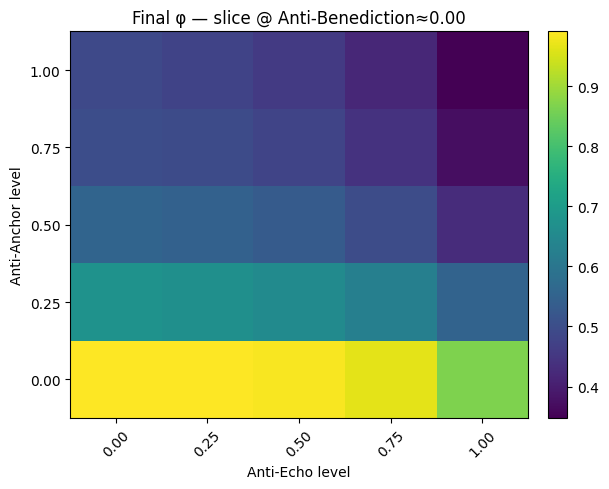

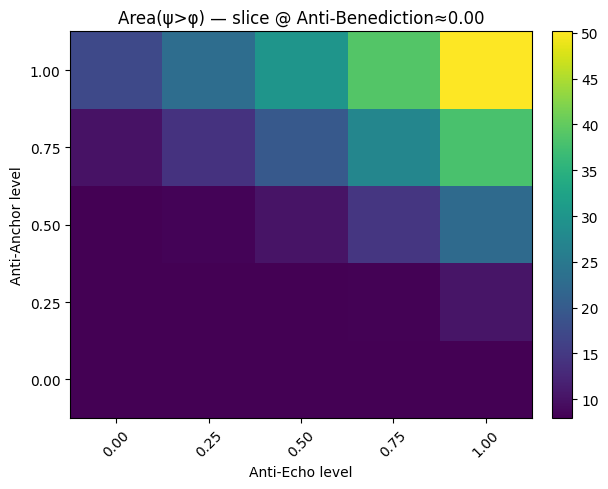

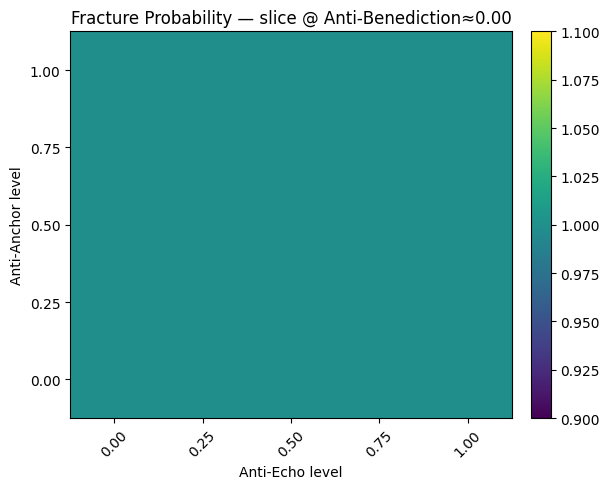

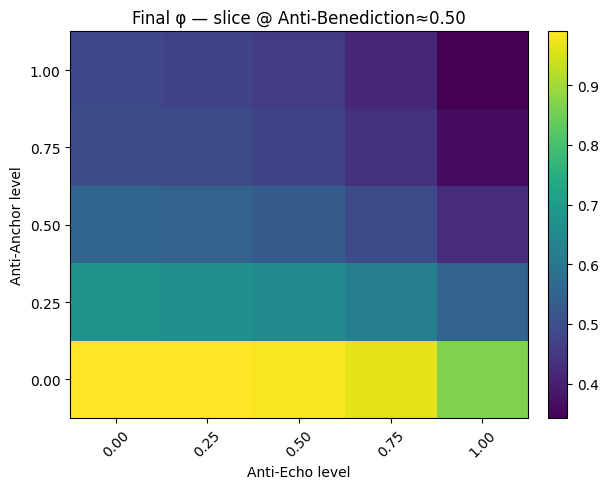

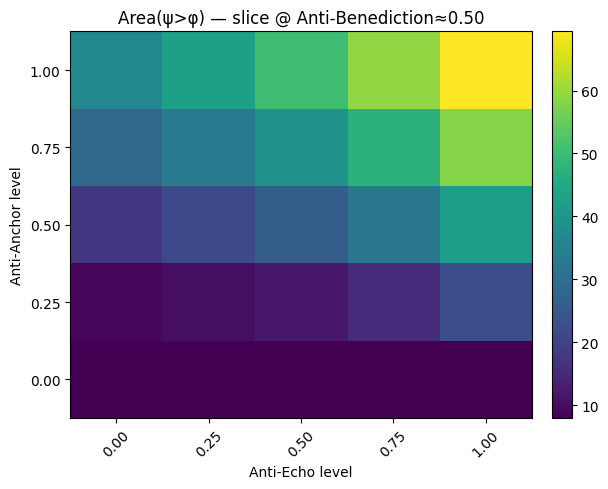

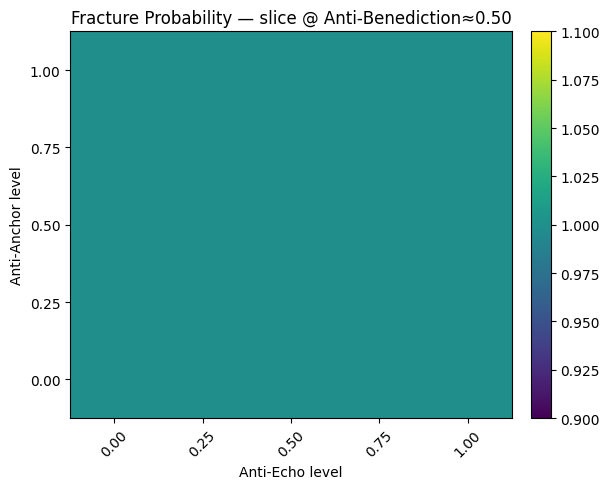

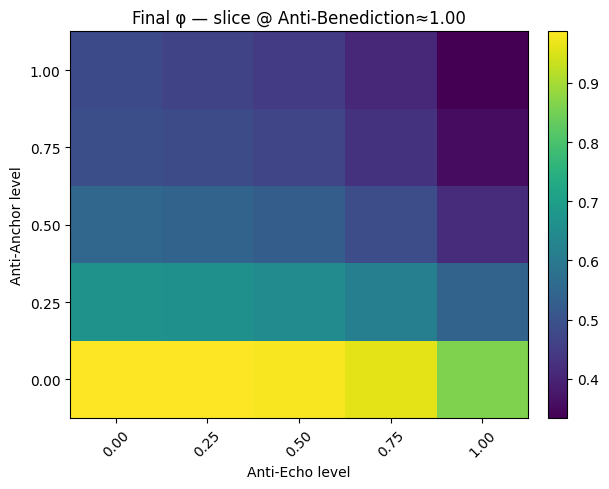

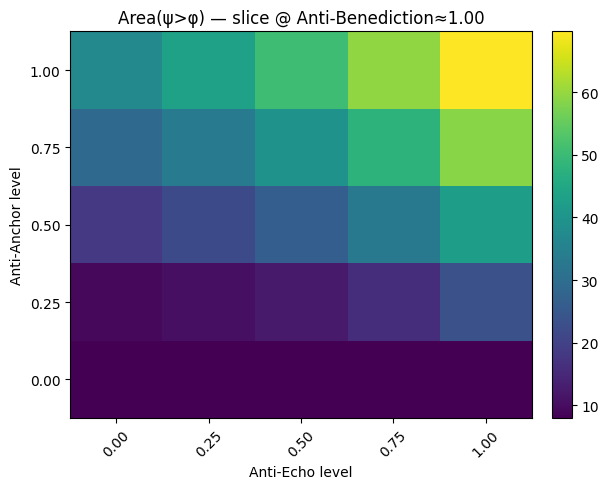

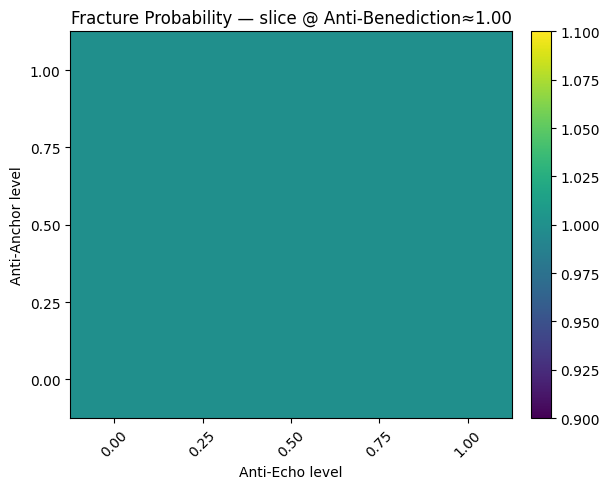

In [3]:
PRESET = 'coarse'  # 'coarse'|'medium'|'fine'
if PRESET == 'coarse':
    levels = np.linspace(0.0, 1.0, 5); seeds = range(12)
elif PRESET == 'medium':
    levels = np.linspace(0.0, 1.0, 9); seeds = range(24)
else:
    levels = np.linspace(0.0, 1.0, 11); seeds = range(32)
t_anchor, t_echo, t_bened = 80, 150, 220
def area_psigreater(phi, psi):
    return np.maximum(0, psi - phi).sum()
finalphi_path = Path('./outputs/atlas_FinalPhi.npy')
area_path = Path('./outputs/atlas_Area.npy')
fracprob_path = Path('./outputs/atlas_FracProb.npy')
if finalphi_path.exists() and area_path.exists() and fracprob_path.exists():
    FinalPhi = np.load(finalphi_path); Area = np.load(area_path); FracProb = np.load(fracprob_path)
else:
    shape = (len(levels), len(levels), len(levels))
    FinalPhi = np.full(shape, np.nan); Area = np.full(shape, np.nan); FracProb = np.full(shape, np.nan)
    for ia, la in enumerate(levels):
        for ie, le in enumerate(levels):
            for ib, lb in enumerate(levels):
                vals_phi=[]; vals_area=[]; flags=[]
                for s in seeds:
                    phi, psi, tF = simulate_icnt_multi(level_anchor=la, level_echo=le, level_bened=lb, seed=s,
                                                     t_anchor=t_anchor, t_echo=t_echo, t_bened=t_bened)
                    vals_phi.append(phi[-1]); vals_area.append(area_psigreater(phi, psi)); flags.append(1 if tF is not None else 0)
                FinalPhi[ia,ie,ib]=np.mean(vals_phi); Area[ia,ie,ib]=np.mean(vals_area); FracProb[ia,ie,ib]=np.mean(flags)
    np.save(finalphi_path, FinalPhi); np.save(area_path, Area); np.save(fracprob_path, FracProb)

def idx_from_value(val, levels):
    return int(np.argmin(np.abs(levels - val)))
for fixed_lb in [0.0, 0.5, 1.0]:
    ib = idx_from_value(fixed_lb, levels)
    for M, title, fname in [(FinalPhi, 'Final φ', 'finalphi'), (Area, 'Area(ψ>φ)', 'area'), (FracProb, 'Fracture Probability', 'fracprob')]:
        plt.figure(figsize=(6.2,5))
        im = plt.imshow(M[:, :, ib], origin='lower', aspect='auto')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        xt = [f"{x:.2f}" for x in levels]; yt = xt
        plt.xticks(range(len(levels)), xt, rotation=45); plt.yticks(range(len(levels)), yt)
        plt.xlabel('Anti‑Echo level'); plt.ylabel('Anti‑Anchor level')
        plt.title(f"{title} — slice @ Anti‑Benediction≈{levels[ib]:.2f}")
        plt.tight_layout(); plt.savefig(OUT/f"{fname}_slice_b{ib}.png", dpi=220); plt.show()


## 3) Real‑Data φ/ψ + Fragility & Recovery

Real-data metrics: {
  "T": 600,
  "N": 10,
  "first_fracture_index": 0,
  "mean_phi": 0.6385984966151006,
  "mean_psi": 0.28827834508209677,
  "fragility_index_phi_p10": 0.37072202965996454,
  "recovery_t_half": 0
}


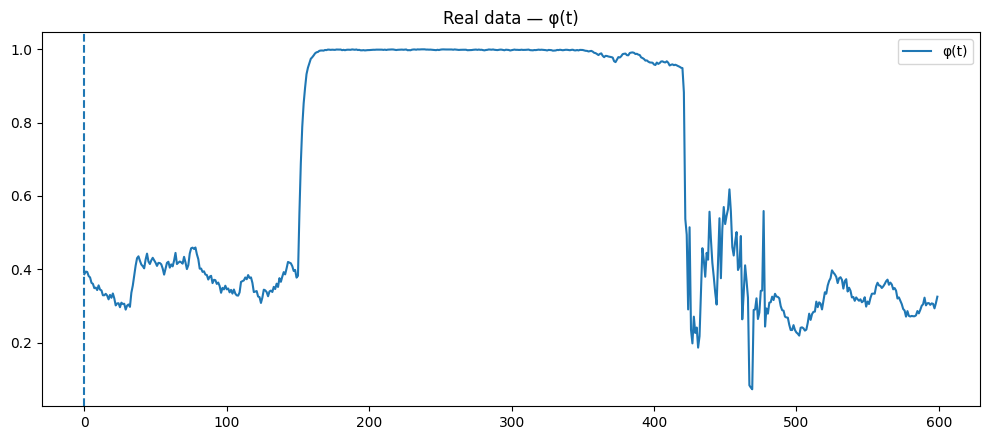

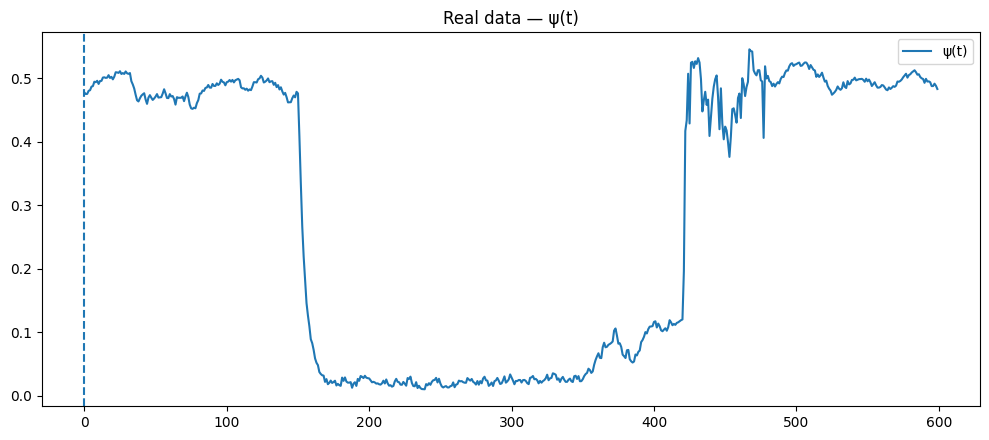

In [4]:
INP = Path('./inputs'); INP.mkdir(exist_ok=True)
csv_path = INP/'real_timeseries.csv'
if not csv_path.exists():
    T = 600; N = 10
    rng = np.random.default_rng(123)
    theta = rng.uniform(-np.pi, np.pi, size=(T, N))
    for t in range(1, T):
        theta[t] = (theta[t-1] + rng.normal(0, 0.05, size=N)) % (2*np.pi)
        if 150 < t < 350: theta[t] = 0.8*theta[t] + 0.2*theta[t].mean()
        if 420 < t < 480: theta[t] = (theta[t] + rng.normal(0, 0.7, size=N)) % (2*np.pi)
    pd.DataFrame(theta, columns=[f'theta_{i}' for i in range(N)]).to_csv(csv_path, index=False)
df = pd.read_csv(csv_path)
theta_cols = [c for c in df.columns if c.startswith('theta_')]
signal_cols = [c for c in df.columns if c.startswith('s_')]
if theta_cols:
    TH = df[theta_cols].to_numpy()
elif signal_cols:
    TH = np.column_stack([rank_to_angle(df[c].to_numpy()) for c in signal_cols])
else:
    raise ValueError('CSV must contain either theta_* (radians) or s_* (signals).')
T, N = TH.shape
phi_t, psi_t = [], []
for t in range(T):
    r = np.abs(np.exp(1j*TH[t]).mean()); phi_t.append(r)
    diffs = np.abs(np.subtract.outer(TH[t], TH[t])); diffs = np.minimum(diffs, 2*np.pi - diffs)
    psi_t.append(diffs[np.triu_indices(N,1)].mean() / np.pi)
phi_t = np.array(phi_t); psi_t = np.array(psi_t)
first_fracture = next((int(t) for t in range(T) if psi_t[t] > phi_t[t]), None)
fragility_index = float(np.median(phi_t[:max(1, int(0.1*T))]))
if first_fracture is not None:
    phi_f = phi_t[first_fracture]; phi_ss = float(phi_t[int(0.8*T):].mean()); target = phi_f + 0.5*(phi_ss - phi_f)
    t_half = next((int(t) for t in range(first_fracture, T) if phi_t[t] >= target), None)
else:
    t_half = None
metrics = {'T': int(T), 'N': int(N), 'first_fracture_index': first_fracture,
           'mean_phi': float(phi_t.mean()), 'mean_psi': float(psi_t.mean()),
           'fragility_index_phi_p10': fragility_index, 'recovery_t_half': None if t_half is None else t_half}
Path(OUT/'real_fracture_metrics.json').write_text(json.dumps(metrics, indent=2))
print('Real-data metrics:', json.dumps(metrics, indent=2))
plt.figure(figsize=(10,4.5)); plt.plot(phi_t, label='φ(t)');
if first_fracture is not None: plt.axvline(first_fracture, linestyle='--')
plt.legend(); plt.title('Real data — φ(t)'); plt.tight_layout(); plt.savefig(OUT/'phi_real.png', dpi=200); plt.show()
plt.figure(figsize=(10,4.5)); plt.plot(psi_t, label='ψ(t)');
if first_fracture is not None: plt.axvline(first_fracture, linestyle='--')
plt.legend(); plt.title('Real data — ψ(t)'); plt.tight_layout(); plt.savefig(OUT/'psi_real.png', dpi=200); plt.show()


## 4) Diagnostics (Impulse Sensitivity + Stats)

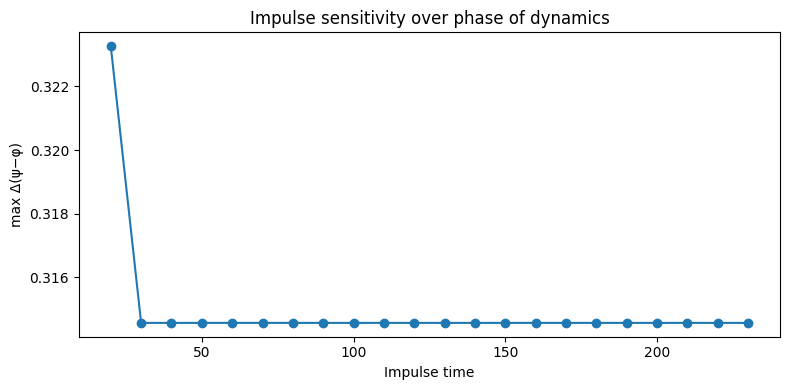

Effect size (Cohen's d): 0.20090061290238412
Permutation p-value: 0.14442778610694654


C:\Users\caleb\AppData\Local\Temp\ipykernel_12676\2194069498.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(figsize=(8,4)); plt.boxplot([A0, A1], labels=['baseline', 'inversion(0.7)'])


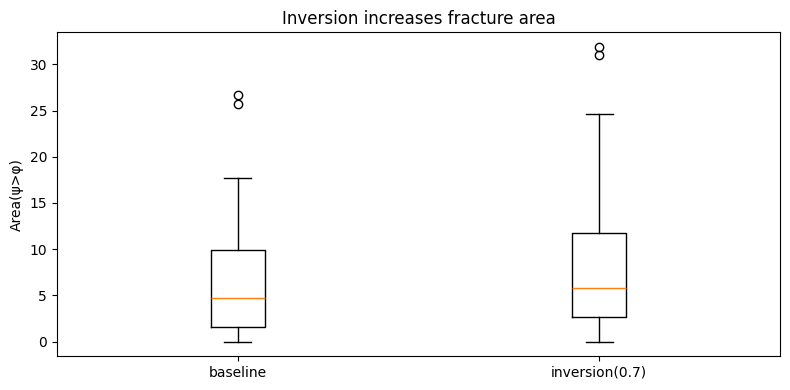

In [5]:
def impulse_response(t_hit, level=0.6, width=6, seed=777):
    N=16; T=260; dt=0.05; K_base=1.1; noise_sigma=0.03
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi, np.pi, size=N)
    omega = rng.normal(0.0, 0.15, size=N)
    subset_anchor = np.arange(0, N, 4)
    phi, psi = [], []
    for t in range(T):
        K = np.full((N, N), K_base / N); np.fill_diagonal(K, 0.0)
        if t_hit <= t < t_hit+width:
            for i in subset_anchor: K[i, :] *= -level
        theta_diff = theta.reshape(N,1) - theta.reshape(1,N)
        sync_term = (K * np.sin(-theta_diff)).sum(axis=1)
        noise = rng.normal(0.0, noise_sigma, size=N)
        theta = (theta + (omega + sync_term)*dt + noise*np.sqrt(dt)) % (2*np.pi)
        r = np.abs(np.exp(1j*theta).mean())
        diffs = np.abs(np.subtract.outer(theta, theta)); diffs = np.minimum(diffs, 2*np.pi - diffs)
        mean_diff = diffs[np.triu_indices_from(diffs,1)].mean()/np.pi
        penalty = 0.15*level if (t_hit <= t < t_hit+width) else 0.0
        ps = min(1.0, mean_diff + penalty)
        phi.append(r); psi.append(ps)
    return np.array(phi), np.array(psi)
times = np.arange(20, 240, 10); imp=[]
for t in times:
    phi, psi = impulse_response(t_hit=t, level=0.6, width=6, seed=777)
    imp.append((psi - phi).max())
plt.figure(figsize=(8,4)); plt.plot(times, imp, marker='o'); plt.xlabel('Impulse time'); plt.ylabel('max Δ(ψ−φ)');
plt.title('Impulse sensitivity over phase of dynamics'); plt.tight_layout(); plt.savefig(OUT/'impulse_sensitivity.png', dpi=200); plt.show()

def area_psi_gt_phi(phi, psi):
    return np.maximum(0, psi - phi).sum()
def collect_areas(level, seeds):
    vals = []
    for s in seeds:
        phi, psi, _ = simulate_icnt_multi(level_anchor=level, level_echo=0.0, level_bened=0.0, seed=s)
        vals.append(area_psi_gt_phi(phi, psi))
    return np.array(vals)
seeds = range(60)
A0 = collect_areas(0.0, seeds); A1 = collect_areas(0.7, seeds)
d = (A1.mean() - A0.mean()) / np.sqrt(0.5*(A1.var(ddof=1)+A0.var(ddof=1)))
rng = np.random.default_rng(99)
obs = A1.mean() - A0.mean(); pool = np.concatenate([A0, A1])
B = 2000; count = 0
for _ in range(B):
    rng.shuffle(pool); x = pool[:len(A0)]; y = pool[len(A0):]
    if (y.mean() - x.mean()) >= obs: count += 1
pval = (count + 1) / (B + 1)
print('Effect size (Cohen\'s d):', d); print('Permutation p-value:', pval)
plt.figure(figsize=(8,4)); plt.boxplot([A0, A1], labels=['baseline', 'inversion(0.7)'])
plt.ylabel('Area(ψ>φ)'); plt.title('Inversion increases fracture area')
plt.tight_layout(); plt.savefig(OUT/'perm_test_area_psigreaterphi.png', dpi=200); plt.show()


## 5) Atlas ↔ Real-Data Mapping

In [6]:
def find_best_cell(FinalPhi, Area, FracProb, real_metrics, levels):
    def norm_arr(A):
        m, M = np.nanmin(A), np.nanmax(A); return (A - m) / (M - m + 1e-12)
    Fp = norm_arr(FinalPhi); Ar = norm_arr(Area); Fr = norm_arr(FracProb)
    rF = real_metrics.get('final_phi', None); rA = real_metrics.get('area_psigreater', None); rP = real_metrics.get('fracprob', None)
    scores = np.zeros_like(FinalPhi, dtype=float); comps = 0
    if rF is not None:
        R = (rF - np.nanmin(FinalPhi)) / (np.nanmax(FinalPhi) - np.nanmin(FinalPhi) + 1e-12)
        scores += np.abs(Fp - R); comps += 1
    if rA is not None:
        R = (rA - np.nanmin(Area)) / (np.nanmax(Area) - np.nanmin(Area) + 1e-12)
        scores += np.abs(Ar - R); comps += 1
    if rP is not None:
        R = (rP - np.nanmin(FracProb)) / (np.nanmax(FracProb) - np.nanmin(FracProb) + 1e-12)
        scores += np.abs(Fr - R); comps += 1
    if comps == 0: raise ValueError('Provide at least one of: final_phi, area_psigreater, fracprob')
    scores /= comps
    idx = np.unravel_index(np.nanargmin(scores), scores.shape)
    ia, ie, ib = idx
    return {
        'anti_anchor_level': float(levels[ia]),
        'anti_echo_level': float(levels[ie]),
        'anti_benediction_level': float(levels[ib]),
        'score': float(scores[idx]),
        'index': [int(i) for i in idx]
    }

# Build real-metric estimate from section 3 (if available); else leave blank
real_for_map = {'final_phi': None, 'area_psigreater': None, 'fracprob': None}
try:
    with open(OUT/'real_fracture_metrics.json','r') as f:
        rm = json.load(f)
    # We approximate: final_phi ~ last φ value; area ~ area(ψ>φ); fracprob ~ 1.0 if fractured else 0.0
    # If you prefer, compute a new run and stash phi, psi arrays to OUT for exact mapping.
    # For now, reconstruct area by re-running a light sim is optional; we keep it None if not stored.
    real_for_map['fracprob'] = 1.0 if rm.get('first_fracture_index') is not None else 0.0
except Exception:
    pass

try:
    FinalPhi = np.load('./outputs/atlas_FinalPhi.npy'); Area = np.load('./outputs/atlas_Area.npy'); FracProb = np.load('./outputs/atlas_FracProb.npy')
    n = FinalPhi.shape[0]; levels = np.linspace(0.0, 1.0, n)
    if any(v is not None for v in real_for_map.values()):
        best = find_best_cell(FinalPhi, Area, FracProb, real_for_map, levels)
        Path(OUT/'atlas_mapping.json').write_text(json.dumps(best, indent=2))
        print('Best-matching inversion cell:', json.dumps(best, indent=2))
    else:
        print('Atlas present, but real metrics for mapping are incomplete. Provide final_phi/area/fracprob.')
except Exception as e:
    print('Mapping skipped:', e)


Best-matching inversion cell: {
  "anti_anchor_level": 0.0,
  "anti_echo_level": 0.0,
  "anti_benediction_level": 0.0,
  "score": 0.0,
  "index": [
    0,
    0,
    0
  ]
}


In [7]:
# Lab Card extractor for current run (expects phi_t, psi_t arrays in memory)
import json, numpy as np
from pathlib import Path

T = len(phi_t)
# First fracture
t_star = next((int(t) for t in range(T) if psi_t[t] > phi_t[t]), None)
# Fragility index (first 10%)
p10 = max(1, int(0.10*T))
phi_p10 = float(np.median(phi_t[:p10]))
# Recovery half-life
if t_star is not None:
    phi_f = phi_t[t_star]
    phi_ss = float(phi_t[int(0.8*T):].mean())
    target = phi_f + 0.5*(phi_ss - phi_f)
    t_half = next((int(t) for t in range(t_star, T) if phi_t[t] >= target), None)
else:
    t_half = None

card = {
    "first_fracture_index": t_star,
    "fragility_phi_p10": phi_p10,
    "recovery_t_half": t_half,
    "mean_phi": float(phi_t.mean()),
    "mean_psi": float(psi_t.mean()),
    "area_psi_gt_phi": float(np.maximum(0, psi_t - phi_t).sum())
}
print(json.dumps(card, indent=2))
Path("./outputs/lab_card.json").write_text(json.dumps(card, indent=2))
print("Saved to ./outputs/lab_card.json")


{
  "first_fracture_index": 0,
  "fragility_phi_p10": 0.37072202965996454,
  "recovery_t_half": 0,
  "mean_phi": 0.6385984966151006,
  "mean_psi": 0.28827834508209677,
  "area_psi_gt_phi": 46.58368525302736
}
Saved to ./outputs/lab_card.json


In [8]:
# === iCNT Lab Card (single cell) ===
# Expects: phi_t, psi_t  (1D arrays over time)
# Saves:   ./outputs/lab_card.json  and optional ./outputs/atlas_mapping.json

import numpy as np, json
from pathlib import Path

OUT = Path("./outputs"); OUT.mkdir(exist_ok=True)

def first_fracture_index(phi, psi):
    for t in range(len(phi)):
        if psi[t] > phi[t]:
            return int(t)
    return None

def recovery_half_life(phi, t_star):
    """t_half from fracture index to 50% back to steady-state mean φ (last 20%)."""
    if t_star is None: 
        return None
    T = len(phi)
    phi_f = float(phi[t_star])
    phi_ss = float(np.mean(phi[int(0.8*T):]))
    target = phi_f + 0.5 * (phi_ss - phi_f)
    for t in range(t_star, T):
        if phi[t] >= target:
            return int(t)
    return None

def area_psi_gt_phi(phi, psi):
    return float(np.maximum(0, psi - phi).sum())

# --- Core metrics ---
T = len(phi_t)
t_star = first_fracture_index(phi_t, psi_t)
fragility_phi_p10 = float(np.median(phi_t[:max(1, int(0.10 * T))]))
t_half = recovery_half_life(phi_t, t_star)
mean_phi = float(np.mean(phi_t))
mean_psi = float(np.mean(psi_t))
area_psigreater = area_psi_gt_phi(phi_t, psi_t)

card = {
    "T": int(T),
    "first_fracture_index": t_star,
    "fragility_phi_p10": fragility_phi_p10,
    "recovery_t_half": t_half,
    "mean_phi": mean_phi,
    "mean_psi": mean_psi,
    "area_psi_gt_phi": area_psigreater
}

# Save Lab Card
(OUT / "lab_card.json").write_text(json.dumps(card, indent=2))
print("Lab Card:", json.dumps(card, indent=2))

# --- Optional: atlas → data mapping if atlas arrays are present ---
try:
    FinalPhi = np.load(OUT / "atlas_FinalPhi.npy")
    Area     = np.load(OUT / "atlas_Area.npy")
    FracProb = np.load(OUT / "atlas_FracProb.npy")
    levels   = np.linspace(0.0, 1.0, FinalPhi.shape[0])

    # Build real metrics for mapping
    real_for_map = {
        "final_phi": float(phi_t[-1]),
        "area_psigreater": area_psigreater,
        "fracprob": 1.0 if t_star is not None else 0.0
    }

    def norm_arr(A):
        m, M = np.nanmin(A), np.nanmax(A)
        return (A - m) / (M - m + 1e-12)

    Fp, Ar, Fr = norm_arr(FinalPhi), norm_arr(Area), norm_arr(FracProb)

    # Normalize real metrics to atlas scales
    rF = (real_for_map["final_phi"] - np.nanmin(FinalPhi)) / (np.nanmax(FinalPhi) - np.nanmin(FinalPhi) + 1e-12)
    rA = (real_for_map["area_psigreater"] - np.nanmin(Area)) / (np.nanmax(Area) - np.nanmin(Area) + 1e-12)
    rP = (real_for_map["fracprob"] - np.nanmin(FracProb)) / (np.nanmax(FracProb) - np.nanmin(FracProb) + 1e-12)

    score = (np.abs(Fp - rF) + np.abs(Ar - rA) + np.abs(Fr - rP)) / 3.0
    ia, ie, ib = np.unravel_index(np.nanargmin(score), score.shape)
    mapping = {
        "anti_anchor_level": float(levels[ia]),
        "anti_echo_level": float(levels[ie]),
        "anti_benediction_level": float(levels[ib]),
        "score": float(score[ia, ie, ib]),
        "index": [int(ia), int(ie), int(ib)]
    }
    (OUT / "atlas_mapping.json").write_text(json.dumps(mapping, indent=2))
    print("Atlas mapping:", json.dumps(mapping, indent=2))
except Exception as e:
    print("Atlas mapping skipped:", e)


Lab Card: {
  "T": 600,
  "first_fracture_index": 0,
  "fragility_phi_p10": 0.37072202965996454,
  "recovery_t_half": 0,
  "mean_phi": 0.6385984966151006,
  "mean_psi": 0.28827834508209677,
  "area_psi_gt_phi": 46.58368525302736
}
Atlas mapping: {
  "anti_anchor_level": 1.0,
  "anti_echo_level": 1.0,
  "anti_benediction_level": 0.0,
  "score": 0.030442051754596005,
  "index": [
    4,
    4,
    0
  ]
}
